Alex Goldsmith <br>
ECON 9000 <br>
Problem Set 1 <br>

In [1]:
#Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read data to DataFrame
df = pd.read_json('currencies.json')

In [3]:
#Let's get a sense of the data
df.head()

,date,day_close,day_high,day_low,day_market_cap,day_open,day_volume,long_name,market_rank,short_name
0,2019-04-09,0.358662,0.368276,0.341337,"210,789,830",0.349616,"25,531,764",0x,#38,(ZRX)
1,2019-04-08,0.349616,0.368514,0.338603,"205,422,221",0.356285,"25,068,719",0x,#38,(ZRX)
2,2019-04-09,0.000049,0.000049,0.000037,"1,296,018",0.000042,225,Elite,#1262,(1337)
3,2019-04-07,0.356219,0.368567,0.350586,"209,301,552",0.353494,"28,228,595",0x,#38,(ZRX)
4,2019-04-08,0.000042,0.000046,0.000039,"1,108,819",0.000043,162,Elite,#1262,(1337)


In [4]:
#DataFrame structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667421 entries, 0 to 667420
Data columns (total 10 columns):
date              667421 non-null datetime64[ns]
day_close         667421 non-null object
day_high          667421 non-null object
day_low           667421 non-null object
day_market_cap    667421 non-null object
day_open          667421 non-null object
day_volume        667421 non-null object
long_name         667421 non-null object
market_rank       667421 non-null object
short_name        667421 non-null object
dtypes: datetime64[ns](1), object(9)
memory usage: 50.9+ MB


First off, we need to do some data cleaning. The 'market_rank' variable starts with the pound sign, so we need to get rid of that. The shortened names of the cryptocurrencies are contained in parentheses, so we should elimate those as well. We also need to remove the commas from the closing prices of the cryptocurrencies and convert the values to float. Finally, we need to set the 'date' column as the index for the dataset to work with the API's of our packages such as Pandas and StatsModels.

In [5]:
#Clean market rank variable
df['market_rank'] = (
df['market_rank']
    .str.replace('#','')
    .astype(int)
)

#Clean short name variable
df['short_name'] = (
df['short_name']
    .str.replace('(','')
    .str.replace(')','')
)

#Clean day close variable
df['day_close'] =  (
df['day_close']
    .str.replace(',','')
    .astype(float)
)

#Set date column as index
df = df.set_index('date')

#Check results
df.head()

,day_close,day_high,day_low,day_market_cap,day_open,day_volume,long_name,market_rank,short_name
date,,,,,,,,,
2019-04-09,0.358662,0.368276,0.341337,"210,789,830",0.349616,"25,531,764",0x,38,ZRX
2019-04-08,0.349616,0.368514,0.338603,"205,422,221",0.356285,"25,068,719",0x,38,ZRX
2019-04-09,0.000049,0.000049,0.000037,"1,296,018",0.000042,225,Elite,1262,1337
2019-04-07,0.356219,0.368567,0.350586,"209,301,552",0.353494,"28,228,595",0x,38,ZRX
2019-04-08,0.000042,0.000046,0.000039,"1,108,819",0.000043,162,Elite,1262,1337


Let's sort our original dataset to make it easier to create our series' needed for our prediction models.

In [6]:
#Sort DataFrame
df.sort_values(['market_rank', 'date'], ascending = [True, True], inplace = True)
df.head()

,day_close,day_high,day_low,day_market_cap,day_open,day_volume,long_name,market_rank,short_name
date,,,,,,,,,
2013-04-28,134.21,135.98,132.10,"1,488,566,728",135.30,-,Bitcoin,1,BTC
2013-04-29,144.54,147.49,134.00,"1,603,768,865",134.44,-,Bitcoin,1,BTC
2013-04-30,139.00,146.93,134.05,"1,542,813,125",144.00,-,Bitcoin,1,BTC
2013-05-01,116.99,139.89,107.72,"1,298,954,594",139.00,-,Bitcoin,1,BTC
2013-05-02,105.21,125.60,92.28,"1,168,517,495",116.38,-,Bitcoin,1,BTC


Before we create our models, we should create some example series that are easily feedable into our machine learning model.

In [7]:
#Create Bitcoin and Ethereum series'
BTC = (
df
    .loc[df['short_name'] == 'BTC']
    .loc[:,'day_close']
)
ETH = (
df
    .loc[df['short_name'] == 'ETH']
    .loc[:,'day_close']
)

#Merge to new DataFrame
df_example = pd.DataFrame(columns = ['BTC', 'ETH'])
df_example['BTC'] = BTC
df_example['ETH'] = ETH
#Subset example DataFrame
df_example = df_example['2015-08-07':'2019-04-09']

As we are working with time series data, our machine learning model should take into account the autocorrelation of the values in our series. Let's visualize our data to get a better sense of the nature of the autocorrelation.

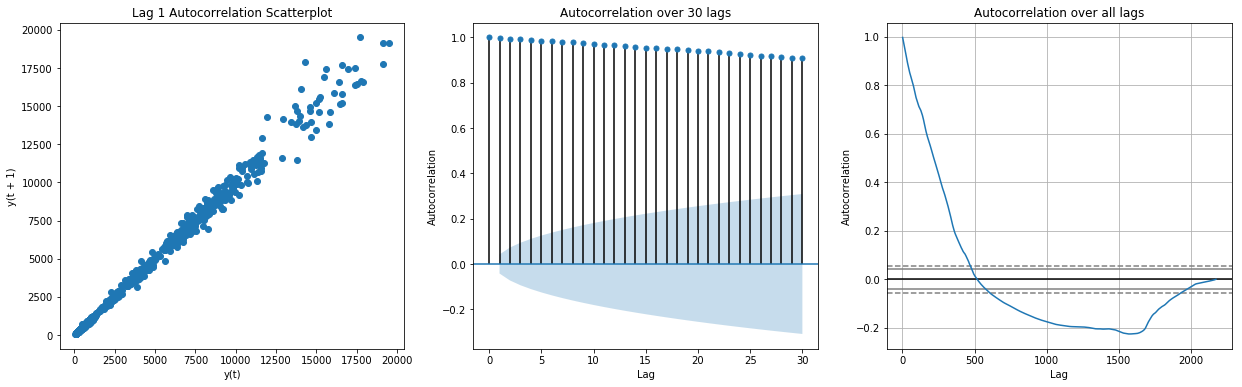

In [8]:
#Visualize Autocorrelation of Bitcoin prices
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(1,3, figsize = (21,6))
a0 = lag_plot(BTC, ax = ax[0])
ax[0].set_title('Lag 1 Autocorrelation Scatterplot')
a1 = plot_acf(BTC, lags = 30, ax = ax[1])
ax[1].set_title('Autocorrelation over 30 lags')
ax[1].set_ylabel('Autocorrelation')
ax[1].set_xlabel('Lag')
a2 = autocorrelation_plot(BTC, ax = ax[2])
ax[2].set_title('Autocorrelation over all lags')
plt.show()

As we can see from the above plots, the day closing prices of Bitcoin are heavily correlated. Our model should take this into account. Now, we should check the stationarity of the series before building our model. We will do this both by plotting and running statistical tests.

D:\Users\Alex\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


NameError: name 'df_example_dff' is not defined

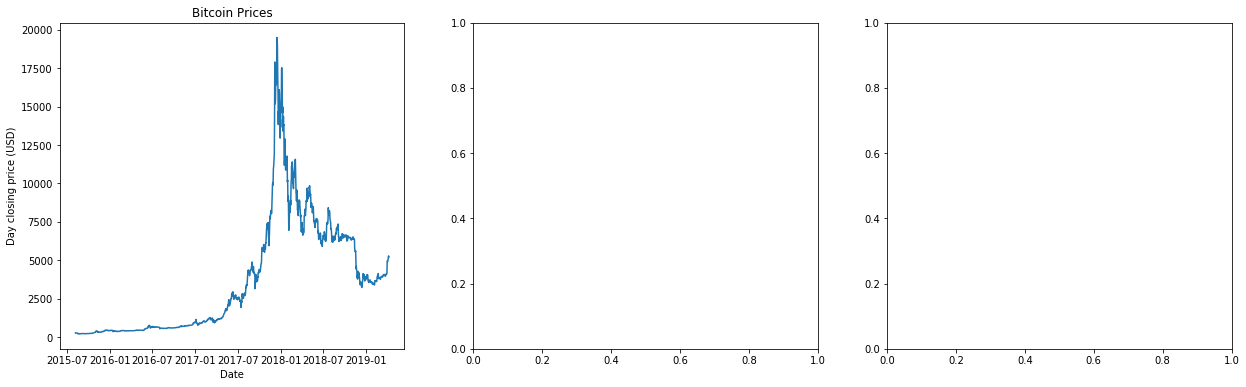

In [9]:
#Take first differences
df_example_diff = df_example.diff()
df_example_diff = df_example_diff.dropna()

#Plot values
fig, ax = plt.subplots(1,3, figsize = (21,6))
ax[0].plot(df_example['BTC'])
ax[0].set_title('Bitcoin Prices')
ax[0].set_ylabel('Day closing price (USD)')
ax[0].set_xlabel('Date')
ax[1].plot(df_example_dff['BTC'])
ax[1].set_title('Bitcoin Price Changes from Previous Day')
ax[1].set_ylabel('Day closing price (USD)')
ax[1].set_xlabel('Date')
plot_acf(df_example_dff.BTC, lags = 30, ax = ax[2])
ax[2].set_title('Autocorrelation of First Differences')
ax[2].set_ylabel('Autocorrelation')
ax[2].set_xlabel('Lag')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(df_example['BTC'])
results2 = adfuller(df_example_diff['BTC'])
#Just print out the p-value
print('The p-value of the Augmented Dickey-Fuller test on prices is: %.3f' %results[1])
print('The p-value of the Augmented Dickey-Fuller test on price changes is: %.3f' %results2[1])
BTC_auto = df_example_diff['BTC'].autocorr()
print("The autocorrelation of Bitcoin change of price from previous day is %4.2f" %(BTC_auto))

Based on our results, we cannot reject the hypthesis that Bitcoin day prices has a unit root, therefore Bitcoin day prices is a non-stationary series. When we take first differences however, the Augmented Dickey-Fuller yields a p-value close to 0. It seams taking first differences of Bitcoin day prices yields a stationary series. <br> <br>
Now it's time to construct our model. We will hold out the last week of prices to validate our model upon, and train the model with the rest of the data. We will then plot the results and print the MSE of our model.

In [ ]:
#Split dataset
train, test = BTC[1:len(BTC)-7], BTC[len(BTC)-7:]

#Train autoregression model
from statsmodels.tsa.ar_model import AR
model = AR(train, freq = 'D')
model_fit = model.fit()

#Make predictions and score results
from sklearn.metrics import mean_squared_error
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

#Plot predictions
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(test, label = 'Actual closing price')
ax.plot(predictions, color='red', label = 'Predicted closing price')
ax.legend()
ax.set_title('Forecast vs actual values of Bitcoin prices')
ax.set_ylabel('Day closing price (USD)')
ax.set_xlabel('Date')
plt.show()

We have successfully created a prediction model for Bitcoin prices! However, we have more data available to us. Can we improve the accuracy of our model by adding data from other series in our dataset? Our next model will include the day prices of Ethereum along with the day prices of Bitcoin.

In [ ]:
#Split dataset
train = df_example[:len(df_example.index)-7]
test = df_example[len(df_example.index)-7:]

#Train autoregression model
from statsmodels.tsa.vector_ar.var_model import VAR
model = VAR(train, freq = 'D')
model_fit = model.fit()

#Make predictions 
prediction = model_fit.forecast(model_fit.y, steps = len(test))

In [ ]:
#Convert predictions to dataframe
pred = pd.DataFrame(prediction, index=test.index, columns=test.columns)

#Print MSE
for i in pred.columns:
    print('Test MSE value for', i, 'is : ', mean_squared_error(pred[i], test[i]))

In [ ]:
#Plot predictions
fig, ax = plt.subplots(1,2, figsize = (16,6))
ax[0].plot(test['BTC'], color = 'b', label = 'Actual prices')
ax[0].plot(pred['BTC'], color = 'c', label = 'Predicted prices')
ax[0].legend()
ax[0].set_title('Bitcoin Actual vs Predicted Prices')
ax[0].set_ylabel('Day closing prices (USD)')
ax[0].set_xlabel('Date')
ax[1].plot(test['ETH'], color = 'r', label = 'Actual prices')
ax[1].plot(pred['ETH'], color = 'm', label = 'Predicted prices')
ax[1].legend()
ax[1].set_title('Ethereum Actual vs Predicted Prices')
ax[1].set_ylabel('Day closing prices (USD)')
ax[1].set_xlabel('Date')
plt.show()

Although the plotted prediction for the Vector Autoregression Model appears simpler than the more flexible fit from the univariate Autoregression Model, it actually performs better for predicting Bitcoin Prices according to the measure of test MSE (21671 vs 27848).  <br> <br>
In theory, we can continue this process, improving our model by adding historical data from other cryptocurrencies (so long as there is sufficient correlation between the series'). Although we will not perform this process here, designing an optimal model from our dataset requires us to beware of adding variables to the model with little added value of prediction. We would be best served to include only data from cryptocurrencies whose prices vary with that of Bitcoin. 